In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import datetime
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
#!pip install tensorflow 

In [3]:
spall = pd.read_csv('../data/sp500_cleaned-final.csv', low_memory=False,parse_dates=['Date'])
sp=spall


# cpi = pd.read_csv("../data/cpi_alpha_cleaned-final.csv",parse_dates=['Date'])
# inflation = pd.read_csv("../data/inflation_cleaned-final.csv", parse_dates=['Date'])
# intRate = pd.read_csv("../data/int_rates_cleaned_final.csv", parse_dates=['Date'])
# nfpayroll = pd.read_csv("../data/nfpayroll_cleaned-final.csv", parse_dates=['Date'])
# unemployment = pd.read_csv("../data/unemployment-cleaned-final.csv", parse_dates=['Date'])
# vix = pd.read_csv("../data/vix_cleaned_final.csv", parse_dates=['Date'])

In [4]:
#Global variables
date_Filter = '1990-01-01'

## Data cleanup and tranformation

### Scale all dataframes, dropna columns and dropna

In [5]:
scaler = MinMaxScaler()

# SP500
#Filter the SP data from 01-01-1990
sp = sp[sp['Date'] > date_Filter]
sp = sp.drop(['Open','High','Low'], axis=1).sort_values(by='Date',ascending=True) 
# Scale Close price
sp[['Close']] = scaler.fit_transform(sp[['Close']])
print(sp)



            Date     Close
15549 1990-01-02  0.014270
15550 1990-01-03  0.014063
15551 1990-01-04  0.013377
15552 1990-01-05  0.012606
15553 1990-01-08  0.012959
...          ...       ...
23953 2023-05-12  0.850597
23954 2023-05-15  0.853307
23955 2023-05-16  0.847446
23956 2023-05-17  0.858304
23957 2023-05-18  0.867030

[8409 rows x 2 columns]


In [6]:
sp.index = sp.pop('Date')
sp

,Close
Date,
1990-01-02,0.014270
1990-01-03,0.014063
1990-01-04,0.013377
1990-01-05,0.012606
1990-01-08,0.012959
...,...
2023-05-12,0.850597
2023-05-15,0.853307
2023-05-16,0.847446


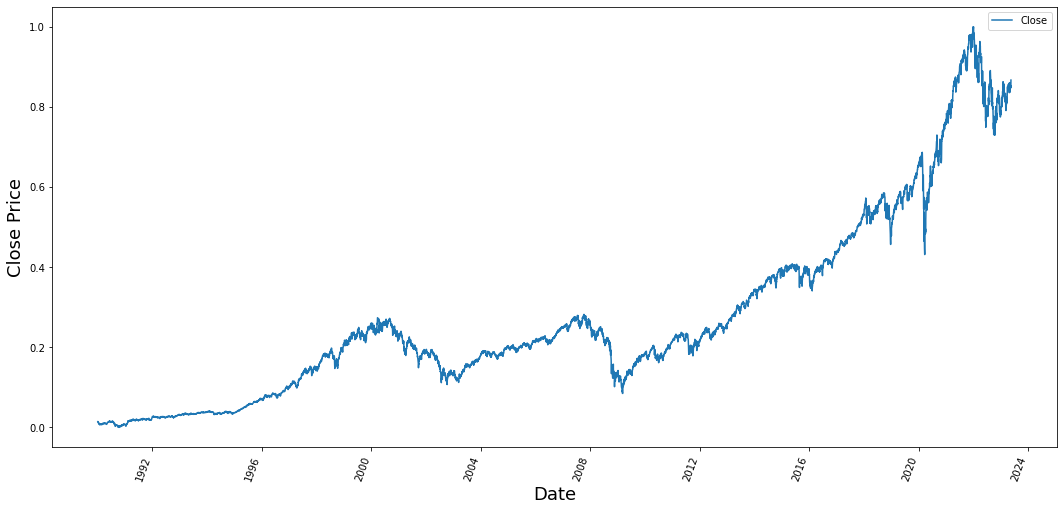

In [7]:
sp.plot.line(y="Close", use_index=True, figsize = (18,9))
plt.xticks(rotation=70)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [8]:
import datetime

def convert_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = convert_datetime('2020-03-19')
datetime_object

datetime.datetime(2020, 3, 19, 0, 0)

In [9]:
def create_target_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = convert_datetime(first_date_str)
  last_date  = convert_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Close-{n-i}'] = X[:, i]
  
  ret_df['Close'] = Y

  return ret_df

In [10]:
target_df = create_target_df(sp, 
                                '2021-05-01', 
                                '2023-05-18', 
                                n=3)
target_df

,Date,Close-3,Close-2,Close-1,Close
0,2021-05-01,0.864513,0.863727,0.870012,0.863280
1,2021-05-04,0.870012,0.863280,0.865833,0.859612
2,2021-05-05,0.863280,0.865833,0.859612,0.860263
3,2021-05-06,0.865833,0.859612,0.860263,0.867823
4,2021-05-07,0.859612,0.860263,0.867823,0.874706
...,...,...,...,...,...
511,2023-05-12,0.849506,0.853609,0.852049,0.850597
512,2023-05-15,0.853609,0.852049,0.850597,0.853307
513,2023-05-16,0.852049,0.850597,0.853307,0.847446
514,2023-05-17,0.850597,0.853307,0.847446,0.858304


In [11]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8409 entries, 1990-01-02 to 2023-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8409 non-null   float64
dtypes: float64(1)
memory usage: 389.4 KB


In [12]:
def get_X_y(df):
  df_as_np = df.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = get_X_y(target_df)

dates.shape, X.shape, y.shape

((516,), (516, 3, 1), (516,))

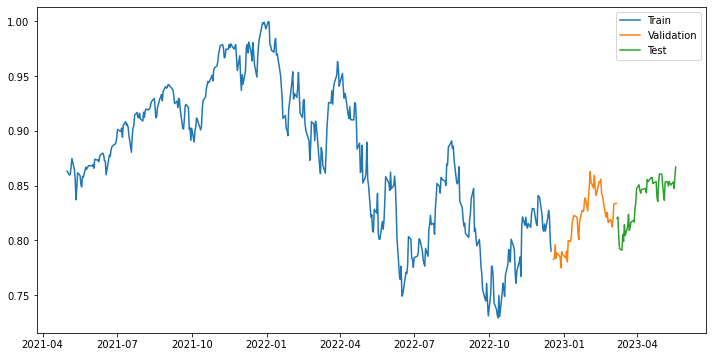

In [13]:
i_80 = int(len(dates) * .8)
i_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:i_80], X[:i_80], y[:i_80]

dates_val, X_val, y_val = dates[i_80:i_90], X[i_80:i_90], y[i_80:i_90]
dates_test, X_test, y_test = dates[i_90:], X[i_90:], y[i_90:]

plt.figure(figsize=(12,6))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [14]:


model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error', 'accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 [==============================] - 1s 24ms/step - loss: 0.3513 - mean_absolute_error: 0.5738 - accuracy: 0.0024 - val_loss: 0.0638 - val_mean_absolute_error: 0.2522 - val_accuracy: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0236 - mean_absolute_error: 0.1337 - accuracy: 0.0024 - val_loss: 0.0344 - val_mean_absolute_error: 0.1852 - val_accuracy: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0109 - mean_absolute_error: 0.0856 - accuracy: 0.0024 - val_loss: 0.0018 - val_mean_absolute_error: 0.0403 - val_accuracy: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0559 - accuracy: 0.0024 - val_loss: 2.2401e-04 - val_mean_absolute_error: 0.0120 - val_accuracy: 0.0000e+00
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0272 - accuracy: 0.0024 - val_loss: 0.0012 - val_mean_

Epoch 39/100
13/13 [==============================] - 0s 3ms/step - loss: 3.6300e-04 - mean_absolute_error: 0.0150 - accuracy: 0.0024 - val_loss: 1.8640e-04 - val_mean_absolute_error: 0.0108 - val_accuracy: 0.0000e+00
Epoch 40/100
13/13 [==============================] - 0s 3ms/step - loss: 3.4844e-04 - mean_absolute_error: 0.0147 - accuracy: 0.0024 - val_loss: 2.9064e-04 - val_mean_absolute_error: 0.0141 - val_accuracy: 0.0000e+00
Epoch 41/100
13/13 [==============================] - 0s 3ms/step - loss: 3.4794e-04 - mean_absolute_error: 0.0148 - accuracy: 0.0024 - val_loss: 1.9454e-04 - val_mean_absolute_error: 0.0110 - val_accuracy: 0.0000e+00
Epoch 42/100
13/13 [==============================] - 0s 3ms/step - loss: 3.4158e-04 - mean_absolute_error: 0.0147 - accuracy: 0.0024 - val_loss: 2.5649e-04 - val_mean_absolute_error: 0.0130 - val_accuracy: 0.0000e+00
Epoch 43/100
13/13 [==============================] - 0s 3ms/step - loss: 3.3550e-04 - mean_absolute_error: 0.0146 - accuracy: 0

13/13 [==============================] - 0s 3ms/step - loss: 2.3073e-04 - mean_absolute_error: 0.0121 - accuracy: 0.0024 - val_loss: 1.1196e-04 - val_mean_absolute_error: 0.0088 - val_accuracy: 0.0000e+00
Epoch 77/100
13/13 [==============================] - 0s 4ms/step - loss: 2.3368e-04 - mean_absolute_error: 0.0120 - accuracy: 0.0024 - val_loss: 1.2009e-04 - val_mean_absolute_error: 0.0090 - val_accuracy: 0.0000e+00
Epoch 78/100
13/13 [==============================] - 0s 3ms/step - loss: 2.2764e-04 - mean_absolute_error: 0.0120 - accuracy: 0.0024 - val_loss: 1.1559e-04 - val_mean_absolute_error: 0.0089 - val_accuracy: 0.0000e+00
Epoch 79/100
13/13 [==============================] - 0s 3ms/step - loss: 2.3267e-04 - mean_absolute_error: 0.0119 - accuracy: 0.0024 - val_loss: 1.1111e-04 - val_mean_absolute_error: 0.0088 - val_accuracy: 0.0000e+00
Epoch 80/100
13/13 [==============================] - 0s 4ms/step - loss: 2.3700e-04 - mean_absolute_error: 0.0123 - accuracy: 0.0024 - val_l

13/13 [==============================] - 0s 584us/step


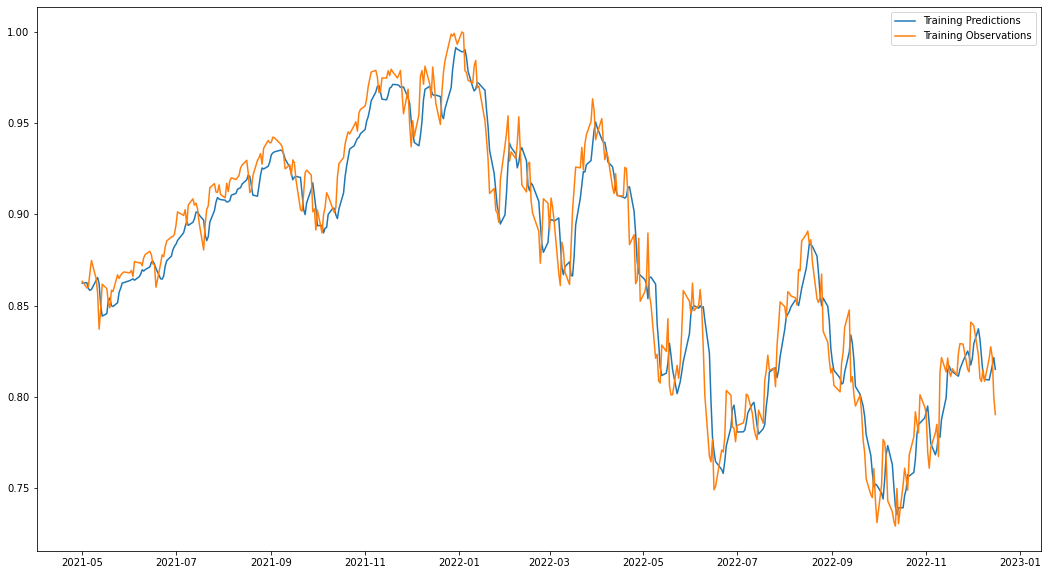

In [15]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(18,10))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 0s/step


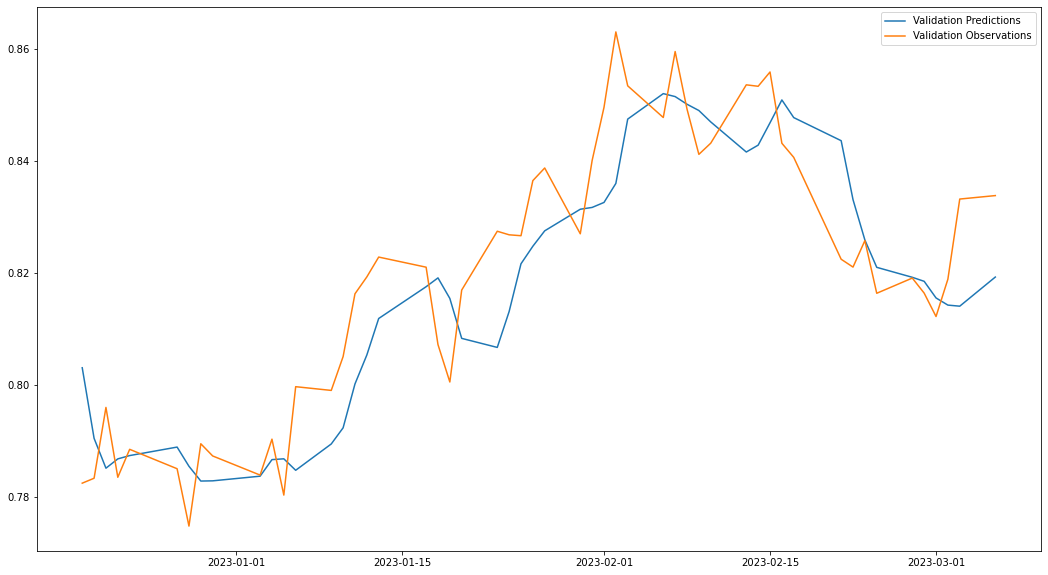

In [16]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(18,10))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [17]:
val_predictions

array([0.80309635, 0.79051286, 0.7851915 , 0.7868478 , 0.787439  ,
       0.7889544 , 0.7855337 , 0.7828979 , 0.7829357 , 0.78376395,
       0.78671676, 0.78686154, 0.78481704, 0.78950816, 0.79238826,
       0.8002065 , 0.80536824, 0.8118745 , 0.81754154, 0.81911653,
       0.8154511 , 0.8083327 , 0.8067208 , 0.8131189 , 0.82162875,
       0.82475585, 0.8275032 , 0.8313549 , 0.8316763 , 0.83256596,
       0.8359547 , 0.84742194, 0.85196334, 0.8514382 , 0.850071  ,
       0.8489549 , 0.84692276, 0.8415552 , 0.8427817 , 0.8467645 ,
       0.8508398 , 0.8476915 , 0.8435727 , 0.83306205, 0.82587385,
       0.8209984 , 0.81922007, 0.81850386, 0.8155404 , 0.81426376,
       0.81407136, 0.81926554], dtype=float32)

2/2 [==============================] - 0s 2ms/step


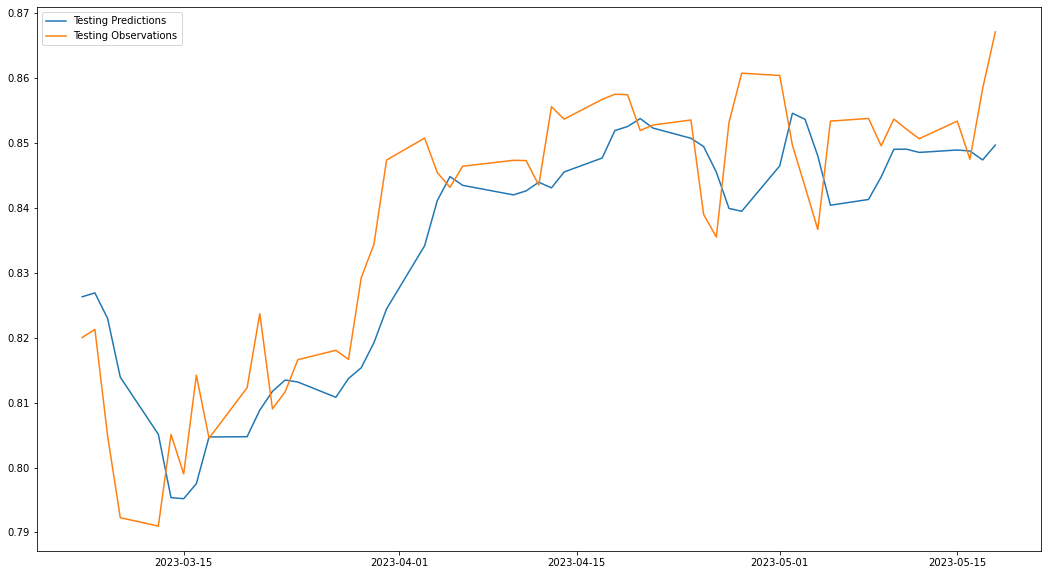

In [18]:
test_predictions = model.predict(X_test).flatten()
plt.figure(figsize=(18,10))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

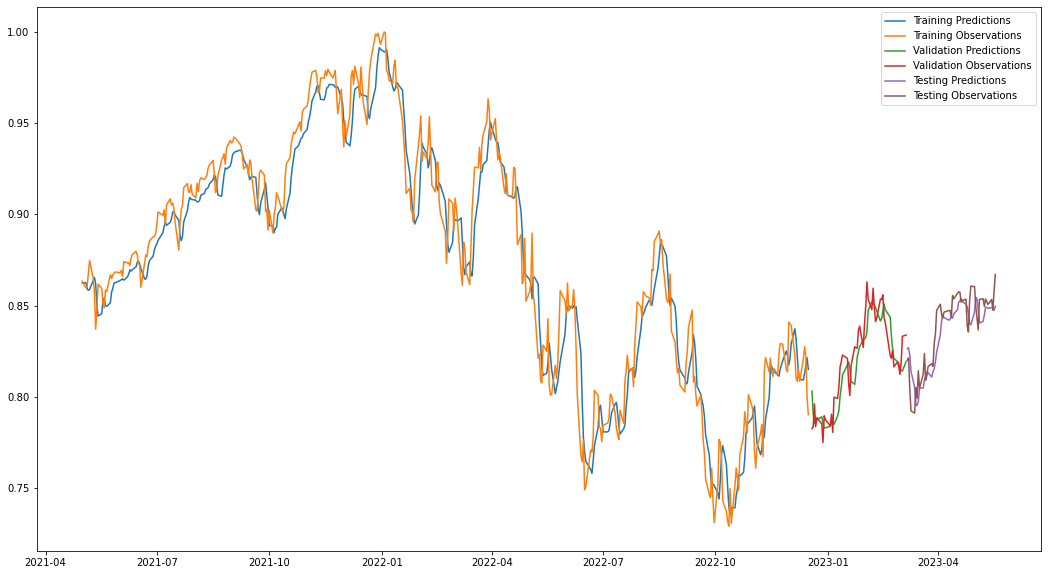

In [19]:
plt.figure(figsize=(18,10))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [20]:
# from copy import deepcopy

# recursive_predictions = []
# recursive_dates = np.concatenate([dates_val, dates_test])

# for target_date in recursive_dates:
#   last_window = deepcopy(X_train[-1])
#   next_prediction = model.predict(np.array([last_window])).flatten()
#   recursive_predictions.append(next_prediction)
#   last_window[-1] = next_prediction

In [21]:
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
# plt.plot(dates_val, val_predictions)
# plt.plot(dates_val, y_val)
# plt.plot(dates_test, test_predictions)
# plt.plot(dates_test, y_test)
# plt.plot(recursive_dates, recursive_predictions)
# plt.legend(['Training Predictions', 
#             'Training Observations',
#             'Validation Predictions', 
#             'Validation Observations',
#             'Testing Predictions', 
#             'Testing Observations',
#             'Recursive Predictions'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


In [23]:
train_predictions

array([0.8622146 , 0.86257213, 0.85930747, 0.8582898 , 0.85880524,
       0.86362547, 0.8653367 , 0.86185974, 0.84992665, 0.84417814,
       0.84555215, 0.8528775 , 0.85411435, 0.8499314 , 0.84944993,
       0.8515235 , 0.8572347 , 0.8594028 , 0.862266  , 0.86253047,
       0.86367804, 0.864127  , 0.86462504, 0.86387616, 0.86573106,
       0.8671089 , 0.86959565, 0.86887807, 0.8697099 , 0.87115604,
       0.8737131 , 0.8742918 , 0.8726553 , 0.8702296 , 0.86464506,
       0.86444324, 0.8661867 , 0.8716849 , 0.8746055 , 0.87705463,
       0.88056713, 0.8824094 , 0.8836079 , 0.885653  , 0.8899422 ,
       0.8933571 , 0.8960718 , 0.8939422 , 0.8956042 , 0.89751244,
       0.9011179 , 0.9014308 , 0.8996999 , 0.8967598 , 0.8885824 ,
       0.8855693 , 0.8877698 , 0.8956968 , 0.90198857, 0.90662336,
       0.90920264, 0.90837485, 0.9080654 , 0.90772825, 0.9067588 ,
       0.9068923 , 0.90754825, 0.91048485, 0.9114518 , 0.9136467 ,
       0.9141844 , 0.91459465, 0.9166044 , 0.91887593, 0.92156

In [24]:
test_predictions

array([0.8262706 , 0.82686764, 0.8229411 , 0.8139004 , 0.8051186 ,
       0.7953631 , 0.7951977 , 0.79751974, 0.80470127, 0.8047368 ,
       0.8088277 , 0.81171703, 0.8134628 , 0.81315345, 0.81080174,
       0.81369966, 0.8153427 , 0.8191954 , 0.824416  , 0.83412623,
       0.8410769 , 0.84476745, 0.84342176, 0.8419519 , 0.84256226,
       0.8439035 , 0.84302753, 0.8454759 , 0.8476267 , 0.8518485 ,
       0.85247093, 0.85369426, 0.85223657, 0.8506591 , 0.8493875 ,
       0.8454514 , 0.8398681 , 0.83942646, 0.8464134 , 0.85452056,
       0.8535703 , 0.8479584 , 0.8403608 , 0.84124506, 0.8447172 ,
       0.84897006, 0.8489814 , 0.8484842 , 0.8488577 , 0.8487061 ,
       0.8473255 , 0.8496135 ], dtype=float32)

In [25]:
val_predictions

array([0.80309635, 0.79051286, 0.7851915 , 0.7868478 , 0.787439  ,
       0.7889544 , 0.7855337 , 0.7828979 , 0.7829357 , 0.78376395,
       0.78671676, 0.78686154, 0.78481704, 0.78950816, 0.79238826,
       0.8002065 , 0.80536824, 0.8118745 , 0.81754154, 0.81911653,
       0.8154511 , 0.8083327 , 0.8067208 , 0.8131189 , 0.82162875,
       0.82475585, 0.8275032 , 0.8313549 , 0.8316763 , 0.83256596,
       0.8359547 , 0.84742194, 0.85196334, 0.8514382 , 0.850071  ,
       0.8489549 , 0.84692276, 0.8415552 , 0.8427817 , 0.8467645 ,
       0.8508398 , 0.8476915 , 0.8435727 , 0.83306205, 0.82587385,
       0.8209984 , 0.81922007, 0.81850386, 0.8155404 , 0.81426376,
       0.81407136, 0.81926554], dtype=float32)

In [ ]:
#scaler.inverse_transform(train_predictions).reshape(-1, 1)